### Libraries

In [1]:
# pip install catboost

In [2]:
import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [3]:
warnings.filterwarnings("ignore")

# 한글 처리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = font_name


### Load data

In [4]:
from dotenv import load_dotenv
import os
from utils.EDA import analysis_임신성공여부, vis_numeric_corr_matrix
load_dotenv()
df_train = pd.read_csv(os.getenv('TRAIN_DATA_PATH')).drop(columns=['ID'])
df_test = pd.read_csv(os.getenv('TEST_DATA_PATH')).drop(columns=['ID'])

df_train.head(8).to_csv('train_sample.csv', encoding = 'utf-8-sig', index = False)

# df_train = pd.read_csv('data/train.csv').drop(columns=['ID'])
# df_test = pd.read_csv('data/test.csv').drop(columns=['ID'])

### Preprocessing

#### 컬럼 제거

In [5]:
# 컬럼 제거
dropped_columns = ['불임 원인 - 여성 요인']

df_train = df_train.drop(columns=dropped_columns, axis=1)
df_test = df_test.drop(columns=dropped_columns, axis=1)

print("제거된 컬럼 개수:", len(dropped_columns))
print("제거된 컬럼:", dropped_columns)
print("df_train.shape:", df_train.shape)
print("df_test.shape:", df_test.shape)

제거된 컬럼 개수: 1
제거된 컬럼: ['불임 원인 - 여성 요인']
df_train.shape: (256351, 67)
df_test.shape: (90067, 66)


#### astype(int)

In [6]:
# '횟수'를 포함하는 컬럼 찾기
count_columns = [col for col in df_train.columns if '횟수' in col]

def extract_number(value):
    if isinstance(value, str):
        return int(value[0])  # 맨 앞자리 숫자로 변환
    return value

for col in count_columns:
    df_train[col] = df_train[col].apply(extract_number).astype(int)
    df_test[col] = df_test[col].apply(extract_number).astype(int)
print("변환된 컬럼:", count_columns)

변환된 컬럼: ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수']


In [7]:
df_train['특정 시술 유형'].value_counts()

특정 시술 유형
ICSI                                   122368
IVF                                     91755
Unknown                                 26939
IUI                                      6100
ICSI:ICSI                                2314
ICSI / BLASTOCYST                        1609
IVF / BLASTOCYST                         1248
IVF:IVF                                  1146
ICSI:IVF                                  873
ICSI / AH                                 769
IVF:ICSI                                  392
IVF / AH                                  319
ICSI:Unknown                              207
IVF:Unknown                               100
ICI                                        96
Generic DI                                 71
IVI                                        23
ICSI / BLASTOCYST:IVF / BLASTOCYST          6
ICSI / BLASTOCYST :IVF / BLASTOCYST         4
FER                                         3
IVF / AH:ICSI / AH                          2
GIFT                     

#### 특정 시술 유형 - ICSI / 배아 생성 주요 이유 - 현재 시술용

In [8]:
def get_dummies(df):
    # 특정 시술 유형 - ICSI
    df['특정 시술 유형 - ICSI'] = np.where(df['시술 유형'] != 'IVF', np.nan,  # 시술 유형이 DI
                            np.where(df['특정 시술 유형'].str.contains('ICSI', na=False), 1, 0))
    df['특정 시술 유형 - unknown'] = np.where(df['시술 유형'] != 'IVF', np.nan,  # 시술 유형이 DI
                            np.where(df['특정 시술 유형'].str.contains('Unknown', na=False), 1, 0))
    df['배아 이유 - 현재 시술용'] = np.where(df['시술 유형'] != 'IVF', np.nan,  # 시술 유형이 DI
                            np.where(df['배아 생성 주요 이유'].str.contains('현재 시술용', na=False), 1, 0))
    df['배아 이유 - 배아 저장용'] = np.where(df['시술 유형'] != 'IVF', np.nan,  # 시술 유형이 DI
                            np.where(df['배아 생성 주요 이유'].str.contains('배아 저장용', na=False), 1, 0))
    df['배아 이유 - 기증용'] = np.where(df['시술 유형'] != 'IVF', np.nan,  # 시술 유형이 DI
                            np.where(df['배아 생성 주요 이유'].str.contains('기증용', na=False), 1, 0))
    df = df.drop(columns=['특정 시술 유형','배아 생성 주요 이유'])
    
    return df

df_train = get_dummies(df_train)
df_test = get_dummies(df_test)

#### 남성/여성/부부 주/부 불임 원인 제거

In [9]:
def drop_cols(df):
    cols = ['남성 주 불임 원인', '남성 부 불임 원인', 
            '여성 주 불임 원인', '여성 부 불임 원인',
            '부부 주 불임 원인', '부부 부 불임 원인']
    
    df = df.drop(columns=cols, errors='ignore')

    return df

df_train = drop_cols(df_train)
df_test = drop_cols(df_test)

#### 배아 해동 경과일이 0보다 큰 값을 가지는 경우 동결 배아 사용 여부 1로 바꾸기

In [10]:
def process(df):
    df.loc[(df['배아 해동 경과일'] > 0), '동결 배아 사용 여부'] = 1
    # df.loc[(df['미세주입된 난자 수'] > 0), '특정 시술 유형 - ICSI'] = 1
    return df

df_train = process(df_train)
df_test = process(df_test)

#### 난자 혼합 경과일, 배아 이식 경과일 groupby median fillna

In [11]:
def fill_nan(df_train, df_test):
    value1 = 0
    value2 = df_train[df_train['시술 유형'] == 'IVF'].groupby(['신선 배아 사용 여부', '총 생성 배아 수'])['배아 이식 경과일'].median().fillna(5)

    for df in [df_train, df_test]:
        # 난자 혼합 경과일
        df.loc[df['시술 유형'] == 'IVF', '난자 혼합 경과일'] = df.loc[df['시술 유형'] == 'IVF', '난자 혼합 경과일'].fillna(value1)
        # 배아 이식 경과일
        df.loc[df['시술 유형'] == 'IVF', '배아 이식 경과일'] = df[df['시술 유형'] == 'IVF'].apply(
            lambda row: value2.get((row['신선 배아 사용 여부'], row['총 생성 배아 수']), row['배아 이식 경과일']) 
            if pd.isna(row['배아 이식 경과일']) else row['배아 이식 경과일'], axis=1
        )

    return df_train, df_test

df_train, df_test = fill_nan(df_train, df_test)

### Feature engineering

In [12]:
def feature_engineering(df):
    epsilon = 1e-5
    
    # 임신/출산 성공률
    df['IVF 시술 대비 임신 성공률'] = df['IVF 임신 횟수'] / df['IVF 시술 횟수']
    
    # 난자
    df['총 난자 수'] = df['수집된 신선 난자 수'] + df['해동 난자 수']
    df['난자 사용률'] = df['혼합된 난자 수'] / df['총 난자 수']
    
    # 배아
    df['총 배아 수'] = df['총 생성 배아 수'] + df['해동된 배아 수']
    df['미세주입 배아 생성 확률'] = df['미세주입에서 생성된 배아 수'] / df['미세주입된 난자 수']
    df['미세주입 배아 이식 확률'] = df['미세주입 배아 이식 수'] / df['미세주입에서 생성된 배아 수']
    df['총 배아 생성 확률'] = df['총 배아 수'] / df['총 난자 수']
    df['신선 + 기증 + 동결'] = df[['신선 배아 사용 여부', '기증 배아 사용 여부', '동결 배아 사용 여부']].sum(axis=1)
    df['배아 저장 비율'] = df['저장된 배아 수'] / (df['총 생성 배아 수'] + epsilon)
    
    # 이식된 배아 수 관련
    df['배아 이식 대비 임신 성공률'] = df['총 임신 횟수'] / df['이식된 배아 수']
    df['배아 이식 대비 출산 성공률'] = df['총 출산 횟수'] / df['이식된 배아 수']
    df['배아 이식 확률'] = df['이식된 배아 수'] / df['총 배아 수']
    df['이식된 배아 대비 이식 기간'] = df['배아 이식 경과일'] / df['이식된 배아 수']

    # 기타
    df['배란자극 * 단일이식'] = df['배란 자극 여부'] * df['단일 배아 이식 여부']
    df['배란자극 * ICSI'] = df['배란 자극 여부'] * df['특정 시술 유형 - ICSI'] 
    df['경과일 차이 - 난자 혼합 * 배아 이식'] = np.abs(df['배아 이식 경과일'] - df['난자 혼합 경과일'])
    df['경과일 차이 - 배아 해동 * 배아 이식'] = np.abs(df['배아 이식 경과일'] - df['배아 해동 경과일'])
    df['경과일 합'] = df[['난자 채취 경과일', '난자 해동 경과일', '난자 혼합 경과일', '배아 해동 경과일', '배아 이식 경과일']].sum(axis=1)
    

    # 바이너리 합
    binary_cols = ['배란 자극 여부', '단일 배아 이식 여부', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부']
    df['바이너리 합'] = df[binary_cols].sum(axis=1)

    # PGD, PGS 합
    pgd_pgs = ['착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', 'PGD 시술 여부', 'PGS 시술 여부']
    df['PGD * PGS 합'] = df[pgd_pgs].sum(axis=1)
    
    # 불임 원인 점수
    infertility_cols = ['불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', 
                        '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인',
                        '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']
    for col in infertility_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].map({'Y': 1, 'N': 0})
    df['불임원인 수'] = df[infertility_cols].sum(axis=1)
    
    # [FIX] 변수 제거 
    # cols = ['총 난자 수', '난자 해동 경과일']
    # df = df.drop(columns=cols, errors='ignore')

    # [ADD] 변수 추가
    # df['배아 이식 * 이식된 배아 수'] = df['배아 이식 경과일'] * df['이식된 배아 수']
    # df['배아 이식 * 이식된 배아 수'].fillna(999)
    return df

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

#### 환자 & 난자 기증자 나이 비교

In [13]:
import numpy as np
def compare_age(df):
    patient_age_map = {'만18-34세': 4, '만35-37세': 5, '만38-39세': 5, '만40-42세': 6, '만43-44세': 6, '만45-50세': 7, '알 수 없음': np.nan}
    donor_age_map = {'만20세 이하': 1, '만21-25세': 2, '만26-30세': 3, '만31-35세': 4, '만36-40세': 5, '만41-45세': 6, '알 수 없음': np.nan}


    df['시술 당시 나이 순위'] = df['시술 당시 나이'].map(patient_age_map)
    df['난자 기증자 나이 순위'] = df['난자 기증자 나이'].map(donor_age_map)

    df['여성 나이 비교'] = df.apply(lambda row: 2 if row['시술 당시 나이 순위'] > row['난자 기증자 나이 순위']
                                  else (1 if row['시술 당시 나이 순위'] == row['난자 기증자 나이 순위'] else 0), axis=1)

    df = df.drop(columns=['시술 당시 나이 순위', '난자 기증자 나이 순위'], errors='ignore')

    return df

df_train = compare_age(df_train)
df_test = compare_age(df_test)

#### 시술 유형이 DI인 경우 -1로 채우기

In [14]:
def di_null(df):
    mask = df['시술 유형'] == 'DI'
    columns_to_fill = [col for col in df.columns if col != '임신 시도 또는 마지막 임신 경과 연수']
    df.loc[mask, columns_to_fill] = df.loc[mask, columns_to_fill].fillna(-1)
    return df

df_train = di_null(df_train)
df_test = di_null(df_test)

In [15]:
# 결측 비율
missing_ratio = df_train.isnull().mean() * 100
print(missing_ratio)

시술 시기 코드                  0.000000
시술 당시 나이                  0.000000
임신 시도 또는 마지막 임신 경과 연수    96.344855
시술 유형                     0.000000
배란 자극 여부                  0.000000
                           ...    
경과일 합                     0.000000
바이너리 합                    0.000000
PGD * PGS 합               0.000000
불임원인 수                    0.000000
여성 나이 비교                  0.000000
Length: 86, dtype: float64


#### NaN, inf 처리

In [16]:
# 결측값 대체
def replace_inf_and_nan(df, value_inf, value_na):
    df.replace([np.inf, -np.inf], value_inf, inplace=True)  # inf, -inf 변환
    df.fillna(value_na, inplace=True)  # NaN 변환
    return df

# 변환 적용
value_inf = 999 # 3 / 0
value_na = 999 # 0 / 0
df_train = replace_inf_and_nan(df_train, value_inf, value_na)
df_test = replace_inf_and_nan(df_test, value_inf, value_na)

#### 로직
'난자 채취 경과일' -> '난자 해동 경과일' -> '난자 혼합 경과일' -> '배아 해동 경과일' -> '배아 이식 경과일'

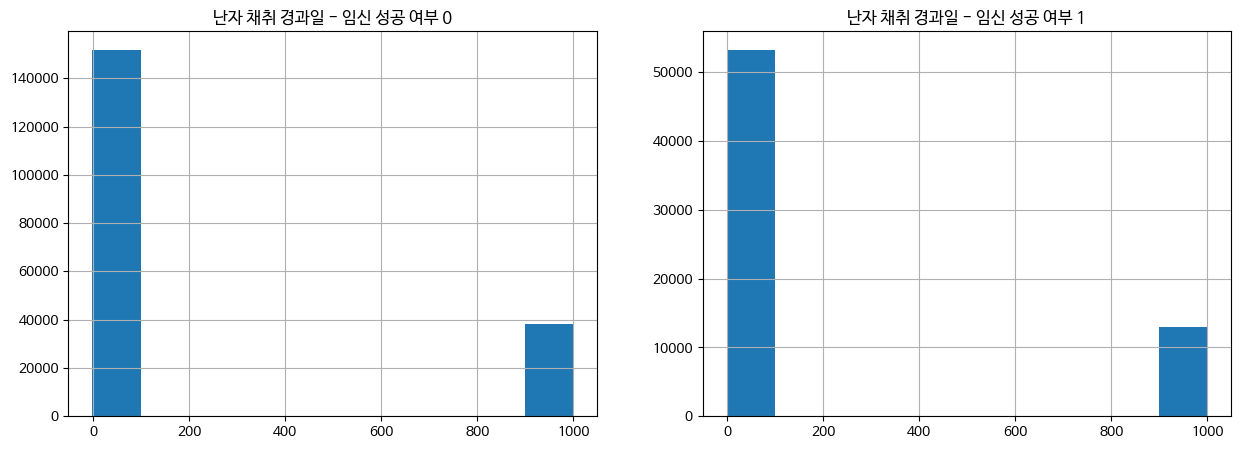

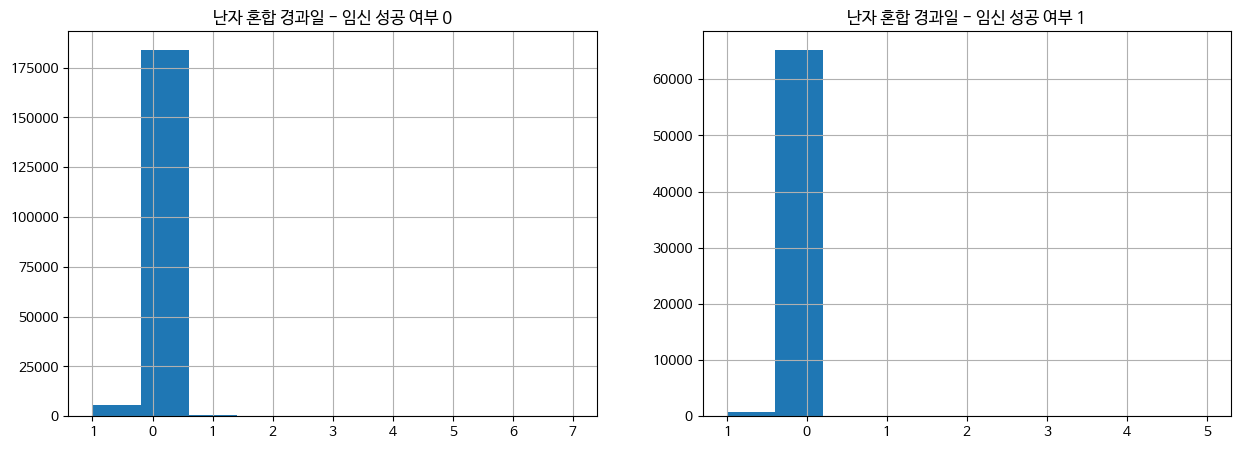

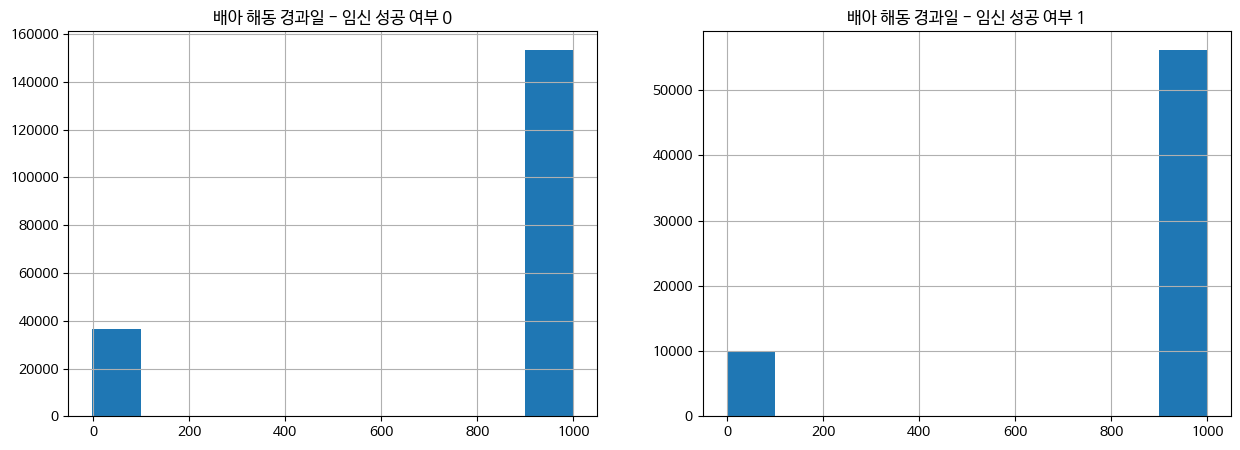

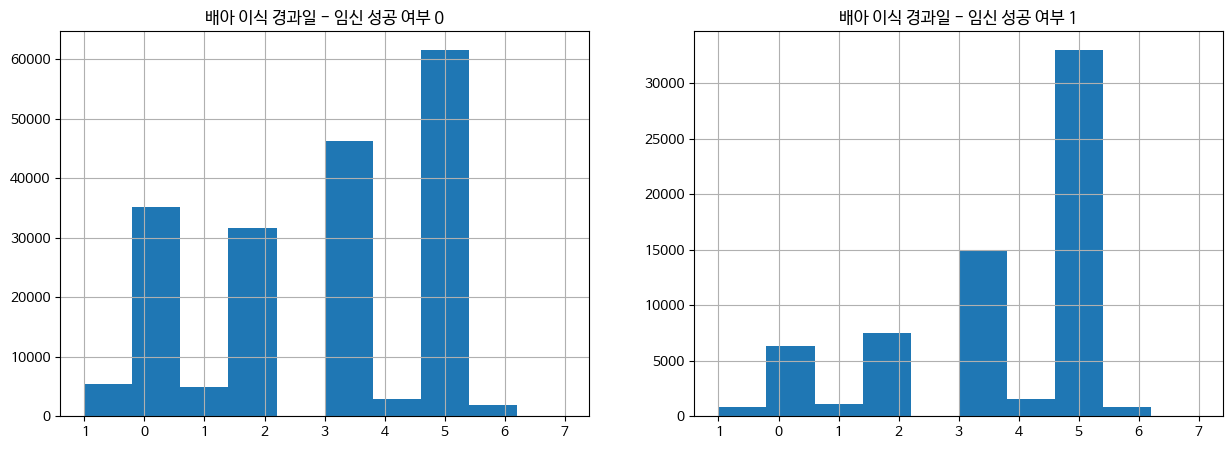

In [17]:
# histogram

def plot_hist(df, col):
    # 임신 성공 여부에 따른 분포 임신 성공 여부는 0, 1로 되어있으므로, 각각 파악
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'{col} - 임신 성공 여부 0')
    df[df['임신 성공 여부'] == 0][col].hist()
    plt.subplot(1, 2, 2)
    plt.title(f'{col} - 임신 성공 여부 1')
    df[df['임신 성공 여부'] == 1][col].hist()
    plt.show()
for col in ['난자 채취 경과일', '난자 혼합 경과일', '배아 해동 경과일', '배아 이식 경과일']:
    plot_hist(df_train, col)

In [18]:

# # [ADD] 변수 추가
# def feature_Age_engineering(df):
#     # 시술 당시 나이 컬럼을 일단 문자열로 변환
#     시술_당시_나이 = df['시술 당시 나이'].astype(str)
    
#     # "만", "세" 제거
#     시술_당시_나이 = 시술_당시_나이.str.replace('만', '', regex=False)
#     시술_당시_나이 = 시술_당시_나이.str.replace('세', '', regex=False)
    
#     # 예: "18-34" 혹은 "35-37" 같은 형태에서 하한/상한 추출
#     # 여기서는 상한 값만 사용한다고 가정
#     시술_당시_나이 = 시술_당시_나이.str.split('-').str[-1]
#     # 알 수 없음 이면 15로 변환
#     # 나이를 int로 변환해서 계산

#     시술_당시_나이 = 시술_당시_나이.replace('알 수 없음', 0)
#     임신_가능_횟수 = (시술_당시_나이.astype(int) - 15) * 12  # 평균적으로 연간 12번

#     # 임신_가능_횟수가 0인 것을 999 결측치로 변환
#     임신_가능_횟수 = np.where(임신_가능_횟수 == 0, np.nan, 임신_가능_횟수)
    
#     df['시술 당시 나이'] = 임신_가능_횟수
#     # df = df.drop(columns=['시술 당시 나이'])
#     return df

# df_train = feature_Age_engineering(df_train)
# df_test = feature_Age_engineering(df_test)

# # df_train['임신 가능 횟수'].value_counts()



# # [ADD] 변수 추가
# def feature_success_rate_engineering(df):
#     df['과거기록 출산 성공률'] = df['총 출산 횟수'] / df['총 임신 횟수']
#     # 총 임신 횟수가 0이면 0으로 변환
#     df['과거기록 출산 성공률'] = np.where(df['총 임신 횟수'] == 0, 0, df['과거기록 출산 성공률'])
    
#     return df

# df_train = feature_success_rate_engineering(df_train)
# df_test = feature_success_rate_engineering(df_test)

# df_train['과거기록 출산 성공률'].isna().sum()


# def feature_4(df):
#     df['총 시술 대비 임신 횟수'] = (df['총 임신 횟수'] / df['클리닉 내 총 시술 횟수'])
#     df['총 시술 대비 임신 횟수'] = np.where(df['클리닉 내 총 시술 횟수'] == 0, 0, df['총 시술 대비 임신 횟수'])
#     df['총 시술 대비 임신 횟수'] = np.where(df['총 임신 횟수'] == 0, 0, df['총 시술 대비 임신 횟수'])
    
#     return df
# df_train = feature_4(df_train)
# df_test = feature_4(df_test)
    

# def feature_5(df):
#     아몰라 = (df['클리닉 내 총 시술 횟수'] / df['이식된 배아 수'])
#     아몰라 = np.where(df['클리닉 내 총 시술 횟수'] == 0, 0, 아몰라)
#     아몰라 = np.where(df['이식된 배아 수'] == 0, 0, 아몰라)
    
#     df['아몰라'] = 아몰라
    
#     return df
# df_train = feature_5(df_train)
# df_test = feature_5(df_test)

import pandas as pd

def feature_6(df):
    # 시술 대비 임신 성공률: (총 임신 횟수 / 총 시술 횟수)
    df['시술 대비 임신 성공률_전체'] = df['총 임신 횟수'] / df['총 시술 횟수'].replace(0, 1) * df['이식된 배아 수'].replace(0, 1)
    
    # 시술 대비 출산 성공률: (총 출산 횟수 / 총 시술 횟수)
    df['시술 대비 출산 성공률_전체'] = df['총 출산 횟수'] / df['총 시술 횟수'].replace(0, 1) * df['이식된 배아 수'].replace(0, 1)
    
    return df

df_train = feature_6(df_train)
df_test = feature_6(df_test)


#### Encoding

In [19]:
# # 시술 시기 코드 one-hot encoding
# df_train = pd.get_dummies(df_train['시술 시기 코드'], prefix='시술_시기', dtype=int).join(df_train)
# df_test = pd.get_dummies(df_test['시술 시기 코드'], prefix='시술_시기', dtype=int).join(df_test)

# df_train.drop(columns=['시술 시기 코드'], inplace=True, axis=1)
# df_test.drop(columns=['시술 시기 코드'], inplace=True, axis=1)

In [20]:
df_train.columns

Index(['시술 시기 코드', '시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '배란 자극 여부',
       '배란 유도 유형', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부',
       '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
       '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '총 시술 횟수',
       '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수',
       'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수',
       '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처',
       '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부',
       '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 채취 경과일', '난자 해동 경과일',
       '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부', '특정 시술 유형 - ICSI',
       '특정 시술 유형 - unknown', '배아 이유 - 현재 시

In [21]:
# object 타입 컬럼 확인
cat_features = list(df_train.select_dtypes(include=['object']).columns)
cat_features

['시술 시기 코드',
 '시술 당시 나이',
 '시술 유형',
 '배란 유도 유형',
 '난자 출처',
 '정자 출처',
 '난자 기증자 나이',
 '정자 기증자 나이']

In [22]:
# LabelEncoder 적용
for col in cat_features:
    le = LabelEncoder() 
    df_train[col] = le.fit_transform(df_train[col])  
    df_test[col] = le.transform(df_test[col]) 

In [23]:
# abs(df_train.corr()['임신 성공 여부']).sort_values(ascending=False)

#### Scaling

In [24]:
# scaling_cols = [
#     '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', 
#     '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수',
#     '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수',
#     '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일',
#     '배아 이식 경과일', '경과일_차이', '불임원인_수', '배아저장비율', '이식된 배아 대비 이식 기간',
#     '총 배아 수', '나이 그룹별 평균 생성 배아 수', '나이 그룹별 평균 이식 배아 수', '나이 그룹별 평균 배아 이식 경과일'
# ]

# scaler = MinMaxScaler()
# df_train[scaling_cols] = scaler.fit_transform(df_train[scaling_cols])
# df_test[scaling_cols] = scaler.transform(df_test[scaling_cols])

### Modeling

In [25]:
X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']
X_test = df_test

In [26]:
df_train['시술 당시 나이'].value_counts()

시술 당시 나이
0    102476
1     57780
2     39247
3     37348
4     12253
5      6918
6       329
Name: count, dtype: int64

#### Stratified K-Fold 

In [27]:
# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = {model: [] for model in ['CatBoost']} # Ensemble
feature_importances = {model: [] for model in ['CatBoost']}
test_proba = {model: [] for model in ['CatBoost']} # Ensemble


for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 정의
    cat_model = CatBoostClassifier(
        iterations=745, learning_rate=0.038577, depth=8, l2_leaf_reg=9.587765,subsample=0.748324, random_strength=0.0,
        min_data_in_leaf=59, leaf_estimation_iterations=1, loss_function='Logloss', eval_metric='AUC', verbose=100, random_seed=123
    )


    # 모델 학습
    for model in [cat_model]: # ensemble_model
        model.fit(X_train, y_train)

    # 평가 함수
    def evaluate_model(model, X_val, y_true):
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        y_pred_proba = np.where(X_val['시술 당시 나이'] == 6, 0, y_pred_proba)

        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'ROC AUC Score': roc_auc_score(y_true, y_pred_proba)
        }

    # 평가 및 변수 중요도 저장
    for model_name, model in zip(metrics.keys(), [cat_model]): # ensemble_model
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

    for model_name, model in zip(['CatBoost'], [cat_model]):
        feature_importances[model_name].append(model.feature_importances_)

    y_test_proba = cat_model.predict_proba(X_test)[:, 1]
    y_test_proba = np.where(X_test['시술 당시 나이'] == 6, 0, y_test_proba)
    # 테스트 데이터 예측 확률 저장
    test_proba['CatBoost'].append(y_test_proba)

===== Fold 1 =====
0:	total: 72.4ms	remaining: 53.9s
100:	total: 1.12s	remaining: 7.17s
200:	total: 2.12s	remaining: 5.73s
300:	total: 2.99s	remaining: 4.41s
400:	total: 3.78s	remaining: 3.24s
500:	total: 4.58s	remaining: 2.23s
600:	total: 5.43s	remaining: 1.3s
700:	total: 6.27s	remaining: 393ms
744:	total: 6.66s	remaining: 0us
===== Fold 2 =====
0:	total: 10.7ms	remaining: 7.99s
100:	total: 1.04s	remaining: 6.62s
200:	total: 2.03s	remaining: 5.49s
300:	total: 2.93s	remaining: 4.32s
400:	total: 3.77s	remaining: 3.23s
500:	total: 4.63s	remaining: 2.26s
600:	total: 5.45s	remaining: 1.3s
700:	total: 6.3s	remaining: 395ms
744:	total: 6.67s	remaining: 0us
===== Fold 3 =====
0:	total: 17ms	remaining: 12.7s
100:	total: 1.04s	remaining: 6.66s
200:	total: 2s	remaining: 5.42s
300:	total: 2.9s	remaining: 4.28s
400:	total: 3.75s	remaining: 3.22s
500:	total: 4.57s	remaining: 2.23s
600:	total: 5.43s	remaining: 1.3s
700:	total: 6.29s	remaining: 395ms
744:	total: 6.69s	remaining: 0us
===== Fold 4 ====

In [28]:
# Val ROC AUC 기준 가중치 적용
print("===== Val ROC AUC 기준 가중치 적용 =====")
print("===== Stratified K-Fold 평균 성능 =====")
for model_name, model_metrics in metrics.items():
    # 모든 fold의 ROC AUC 점수 합계 계산
    total_val_auc = sum(fold_metric['ROC AUC Score'] for fold_metric in model_metrics)
    
    # 각 fold의 가중치 계산
    fold_weights = [fold_metric['ROC AUC Score'] / total_val_auc for fold_metric in model_metrics]
    
    # 각 metric별 가중 평균 계산
    weighted_avg_metrics = {
        metric: sum((fold_metric['ROC AUC Score'] / total_val_auc) * fold_metric[metric]
                    for fold_metric in model_metrics)
        for metric in model_metrics[0]
    }
    
    print(f"\n== {model_name} Model ==")
    print("Fold weights:", fold_weights)
    for metric, value in weighted_avg_metrics.items():
        print(f"{metric}: {value:.6f}")

===== Val ROC AUC 기준 가중치 적용 =====
===== Stratified K-Fold 평균 성능 =====

== CatBoost Model ==
Fold weights: [0.1995821322687741, 0.2000959138286657, 0.1998887843986564, 0.20008561826298119, 0.20034755124092254]
Accuracy: 0.746250
Precision: 0.540034
Recall: 0.120220
F1 Score: 0.196651
ROC AUC Score: 0.740274


In [29]:
# Val ROC AUC 계산 후 Softmax 변환 (정규화) 
print("===== Val ROC AUC 계산 후 Softmax 변환 (정규화)  =====")
print("===== Stratified K-Fold 평균 성능 =====")
T = 0.05 # T가 작을수록 차이가 더 극대화됨

for model_name, model_metrics in metrics.items():
    roc_auc_scores = np.array([fold_metric['ROC AUC Score'] for fold_metric in model_metrics])
    
    # Softmax 변환 적용: 지수 함수를 통해 가중치를 계산하고 정규화
    exp_scores = np.exp(roc_auc_scores / T)
    total_exp = np.sum(exp_scores)
    fold_weights = exp_scores / total_exp
    
    # 각 metric별 가중 평균 계산
    weighted_avg_metrics = {
        metric: sum(fw * fold_metric[metric] for fw, fold_metric in zip(fold_weights, model_metrics))
        for metric in model_metrics[0]
    }
    
    print(f"\n== {model_name} Model ==")
    print("Fold weights:", fold_weights.tolist())
    for metric, value in weighted_avg_metrics.items():
        print(f"{metric}: {value:.6f}")

===== Val ROC AUC 계산 후 Softmax 변환 (정규화)  =====
===== Stratified K-Fold 평균 성능 =====

== CatBoost Model ==
Fold weights: [0.1938736143400048, 0.20138939132092226, 0.19832499709954313, 0.2012359604106853, 0.20517603682884436]
Accuracy: 0.746242
Precision: 0.539966
Recall: 0.120210
F1 Score: 0.196633
ROC AUC Score: 0.740290


In [30]:
# 최종 변수 중요도 평균 계산
df_fi_list = []
for model_name, fi_list in feature_importances.items():
    avg_importance = np.mean(fi_list, axis=0)
    df_fi = pd.DataFrame({
        'Feature': X_train.columns,
        model_name: avg_importance 
    })
    df_fi = df_fi.sort_values(by=model_name, ascending=False).reset_index(drop=True)
    df_fi_list.append(df_fi)
    
df_fi_final = pd.concat(df_fi_list, axis=1)
print(df_fi_final.round(3)[:20])

                   Feature  CatBoost
0          배아 이식 대비 출산 성공률    25.716
1                 이식된 배아 수    23.156
2          이식된 배아 대비 이식 기간     8.677
3                 시술 당시 나이     8.197
4                 배아 저장 비율     3.273
5   경과일 차이 - 난자 혼합 * 배아 이식     2.895
6          배아 이식 대비 임신 성공률     2.115
7                 배아 이식 확률     1.885
8               총 배아 생성 확률     1.755
9                 시술 시기 코드     1.596
10               총 생성 배아 수     1.350
11        IVF 시술 대비 임신 성공률     1.126
12                   난자 출처     1.104
13           클리닉 내 총 시술 횟수     0.942
14                저장된 배아 수     0.940
15           미세주입 배아 생성 확률     0.905
16               난자 채취 경과일     0.717
17                  총 난자 수     0.698
18         시술 대비 임신 성공률_전체     0.697
19               배아 이식 경과일     0.658


In [31]:
print(abs(df_train.corr()['임신 성공 여부']).sort_values(ascending=False)[:20])

임신 성공 여부                  1.000000
배아 이식 대비 임신 성공률           0.239867
배아 이식 대비 출산 성공률           0.239861
이식된 배아 대비 이식 기간           0.239224
경과일 차이 - 난자 혼합 * 배아 이식    0.176005
배아 이식 경과일                 0.175869
경과일 합                     0.173727
이식된 배아 수                  0.161080
총 배아 수                    0.156188
시술 당시 나이                  0.151635
총 생성 배아 수                 0.151343
단일 배아 이식 여부               0.139127
배아 이식 확률                  0.138464
배란자극 * 단일이식               0.137126
바이너리 합                    0.123613
혼합된 난자 수                  0.122375
배아 이유 - 현재 시술용            0.116305
파트너 정자와 혼합된 난자 수          0.111067
미세주입에서 생성된 배아 수           0.095394
총 난자 수                    0.090106
Name: 임신 성공 여부, dtype: float64


In [32]:
# # catboost 기준 변수 중요도 0.05 미만 변수 제거
# df_cat = df_fi_final.iloc[:, :2]
# df_selected = df_cat[df_cat['CatBoost'] > 0.05]
# selected_features = df_selected['Feature'].tolist()

# # 중요도가 높은 피처만 선택하여 새로운 데이터 생성
# X = X[selected_features]
# X_test = X_test[selected_features]

### Re-modeling

In [33]:
# # Stratified K-Fold 설정
# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

# metrics = {model: [] for model in ['CatBoost']} # Ensemble
# feature_importances = {model: [] for model in ['CatBoost']}
# test_proba = {model: [] for model in ['CatBoost']} # Ensemble

# # metrics = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble
# # feature_importances = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']}
# # test_proba = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble

# for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
#     print(f"===== Fold {fold} =====")

#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # 모델 정의
#     cat_model = CatBoostClassifier(
#     iterations=745, 
#     learning_rate=0.038577, 
#     depth=8, 
#     l2_leaf_reg=9.587765,
#     subsample=0.748324, 
#     random_strength=0.0,  # 0으로 설정
#     min_data_in_leaf=59, 
#     leaf_estimation_iterations=1, 
#     loss_function='Logloss', 
#     eval_metric='AUC', 
#     verbose=100, 
#     random_seed=123)

#     # xgb_model = XGBClassifier(
#     #     n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
#     #     gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
#     #     reg_lambda=1.0, verbosity=1, random_state=123
#     # )

#     # lgbm_model = LGBMClassifier(
#     #     n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
#     #     min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
#     #     reg_alpha=0.1, reg_lambda=1.0, verbosity=1, random_state=123
#     # )
    
#     # adaboost_model = AdaBoostClassifier(
#     #     estimator=DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=5, random_state=123),
#     #     n_estimators=500, learning_rate=0.05,
#     #     algorithm="SAMME", random_state=123
#     # )
    
# #     ensemble_model = VotingClassifier(
# #         estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model), ('adaboost', adaboost_model)],
# #         voting='soft', weights=[1, 1, 1, 0.8]
# #     )


#     # 모델 학습
#     for model in [cat_model]: # ensemble_model
# #     for model in [cat_model, xgb_model, lgbm_model, adaboost_model]: # ensemble_model
#         model.fit(X_train, y_train)

#     # 평가 함수
#     def evaluate_model(model, X_val, y_true):
#         y_pred = model.predict(X_val)
#         y_pred_proba = model.predict_proba(X_val)[:, 1]
        
#         # X_val의 이식된 배아 수가 0이면 y_pred_proba가 0이 되게 함
#         y_pred_proba = np.where(X_val['이식된 배아 수'] == 0, 0, y_pred_proba)

#         return {
#             'Accuracy': accuracy_score(y_true, y_pred),
#             'Precision': precision_score(y_true, y_pred),
#             'Recall': recall_score(y_true, y_pred),
#             'F1 Score': f1_score(y_true, y_pred),
#             'ROC AUC Score': roc_auc_score(y_true, y_pred_proba)
#         }

#     # 평가 및 변수 중요도 저장
#     for model_name, model in zip(metrics.keys(), [cat_model]): # ensemble_model
#         metrics[model_name].append(evaluate_model(model, X_val, y_val))

#     for model_name, model in zip(['CatBoost'], [cat_model]):
#         feature_importances[model_name].append(model.feature_importances_)
        
#     # 테스트 데이터 예측 확률 저장
#     # [ADD] 이식된 배아 수가 0이면 0으로 예측하도록 함.
#     y_test_proba = cat_model.predict_proba(X_test)[:, 1]
#     y_test_proba = np.where(X_test['이식된 배아 수'] == 0, 0, y_test_proba)
    
#     test_proba['CatBoost'].append(y_test_proba)
# #     test_proba['XGBoost'].append(xgb_model.predict_proba(X_test)[:, 1])
# #     test_proba['LightGBM'].append(lgbm_model.predict_proba(X_test)[:, 1])
# #     test_proba['AdaBoost'].append(adaboost_model.predict_proba(X_test)[:, 1])
# #     test_proba['Ensemble'].append(ensemble_model.predict_proba(X_test)[:, 1])

In [34]:
# # 평가 지표 평균 출력
# print("===== Stratified K-Fold 평균 성능 =====")
# for model_name, model_metrics in metrics.items():
#     avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
#     print(f"\n== {model_name} Model ==")
#     for metric, value in avg_metrics.items():
#         print(f"{metric}: {value:.6f}")

### Prediction

In [35]:
# # Best AUC 기록한 모델의 pred_proba로 선택
# pred_proba = np.mean(test_proba['CatBoost'], axis=0)
# # pred_proba = np.mean(test_proba['XGBoost'], axis=0)
# # pred_proba = np.mean(test_proba['LightGBM'], axis=0)
# # pred_proba = np.mean(test_proba['AdaBoost'], axis=0)
# # pred_proba = np.mean(test_proba['Ensemble'], axis=0)

In [36]:
# Fold별 Val ROC AUC 기준 가중치 적용한 pred_proba
model = 'CatBoost'
roc_auc_scores = np.array([fold_metrics['ROC AUC Score'] for fold_metrics in metrics[model]])
weights = roc_auc_scores / np.sum(roc_auc_scores)  # 합이 1이 되도록 정규화
test_proba_array = np.array(test_proba[model])
pred_proba = np.average(test_proba_array, axis=0, weights=fold_weights) # fold_weights: 정규화된 가중치

### Submission

In [37]:
# sample_submission = pd.read_csv('data/sample_submission.csv')
# sample_submission.head()

sample_submission = pd.read_csv(os.getenv('SUBMISSION_DATA_PATH'))
sample_submission.head()

,ID,probability
0,TEST_00000,0.0
1,TEST_00001,0.0
2,TEST_00002,0.0
3,TEST_00003,0.0
4,TEST_00004,0.0


In [38]:
# sample_submission['probability'] = pred_proba
# # 저장
# sample_submission.to_csv('data/submission.csv', index=False)
# sample_submission.head()

sample_submission['probability'] = pred_proba
# 저장
import datetime 
now = datetime.datetime.now()
save_path = os.path.join(f'./log/submission/{now.strftime("%Y%m%d_%H%M%S")}_{weighted_avg_metrics["ROC AUC Score"]:.5f}_eiden.csv')
sample_submission.to_csv(save_path, index=False)
sample_submission.head()

,ID,probability
0,TEST_00000,0.002470
1,TEST_00001,0.003691
2,TEST_00002,0.144988
3,TEST_00003,0.117381
4,TEST_00004,0.491083


In [39]:
# 확인용
submission = pd.read_csv(save_path)
submission.head()

,ID,probability
0,TEST_00000,0.002470
1,TEST_00001,0.003691
2,TEST_00002,0.144988
3,TEST_00003,0.117381
4,TEST_00004,0.491083
